In [1]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

def conv3x3(in_planes, out_planes, stride=1, padding=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=padding, bias=False)  #? Why no bias

def conv1x1(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False) #? Why no bias: 如果卷积层之后是BN层，那么可以不用偏置参数，可以节省内存


class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, inplanes, planes, stride=1,dilation=1,  downsample=None,norm_layer=None):
    super(Bottleneck, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
    self.bn1 = norm_layer(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               dilation=dilation, padding=dilation, bias=False)
    self.bn2 = norm_layer(planes)
    self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
    self.bn3 = norm_layer(planes * 4)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample
    self.stride = stride
    self.dilation = dilation

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

class ResNet(nn.Module):
  def __init__(self, block, layers,output_stride, norm_layer=None):
    super(ResNet, self).__init__()
    blocks = [1, 2, 4]
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer
    if output_stride == 16:
        strides = [1, 2, 2, 1]
        dilations = [1, 1, 1, 2]
    else:
        raise NotImplementedError
    self.inplanes = 64

    # conv1 in ppt figure
    self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = norm_layer(self.inplanes)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 64, layers[0],stride=strides[0],dilation=dilations[0])
    self.layer2 = self._make_layer(block, 128, layers[1],stride=strides[1],dilation=dilations[1])
    self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2],dilation=dilations[2])
    self.layer4 = self._make_MG_unit(block, 512, blocks=blocks, stride=strides[3], dilation=dilations[3])

    for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

  def _make_layer(self, block, planes, blocks, stride=1,dilation=1):
    # 生成不同的stage/layer
    # block: block type(basic block/bottle block)
    # blocks: blocks的数量
    norm_layer = self._norm_layer
    downsample = None

    if stride != 1 or self.inplanes != planes * block.expansion:
      # 需要调整维度
      downsample = nn.Sequential(
          conv1x1(self.inplanes, planes * block.expansion, stride),  # 同时调整spatial(H x W))和channel两个方向
          norm_layer(planes * block.expansion)
      )

    layers = []
    layers.append(block(self.inplanes, planes, stride, dilation,downsample, norm_layer)) # 第一个block单独处理
    self.inplanes = planes * block.expansion  # 记录layerN的channel变化，具体请看ppt resnet表格
    for _ in range(1, blocks): # 从1开始循环，因为第一个模块前面已经单独处理
      layers.append(block(self.inplanes, planes,dilation, norm_layer=norm_layer))
    return nn.Sequential(*layers)  # 使用Sequential层组合blocks，形成stage。如果layers=[2,3,4]，那么*layers=？
    
  def _make_MG_unit(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        norm_layer = self._norm_layer
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation=blocks[0]*dilation,
                            downsample=downsample, norm_layer=norm_layer))
        self.inplanes = planes * block.expansion
        for i in range(1, len(blocks)):
            layers.append(block(self.inplanes, planes, stride=1,
                                dilation=blocks[i]*dilation, norm_layer=norm_layer))

        return nn.Sequential(*layers)
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    low_level_feat = x
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    return x,low_level_feat 

def _resnet(arch, block, layers,output_stride, pretrained, progress, **kwargs):
    model = ResNet(block, layers, output_stride,**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [2]:
def resnet101(output_stride,pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck,[3, 4, 23, 3], output_stride,pretrained, progress,
                   **kwargs)


In [3]:
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, BatchNorm):
        super(_ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = BatchNorm(planes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)
class ASPP(nn.Module):
    def __init__(self, output_stride, BatchNorm):
        super(ASPP, self).__init__()
        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError
        inplanes = 2048
        self.aspp1 = _ASPPModule(inplanes, 256, 1, padding=0, dilation=dilations[0], BatchNorm=BatchNorm)
        self.aspp2 = _ASPPModule(inplanes, 256, 3, padding=dilations[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.aspp3 = _ASPPModule(inplanes, 256, 3, padding=dilations[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.aspp4 = _ASPPModule(inplanes, 256, 3, padding=dilations[3], dilation=dilations[3], BatchNorm=BatchNorm)

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(inplanes, 256, 1, stride=1, bias=False),
                                             BatchNorm(256),
                                             nn.ReLU())
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = BatchNorm(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)


In [4]:

class Decoder(nn.Module):
    def __init__(self, num_classes, BatchNorm):
        super(Decoder, self).__init__()
        low_level_inplanes = 256

        self.conv1 = nn.Conv2d(low_level_inplanes, 48, 1, bias=False)
        self.bn1 = BatchNorm(48)
        self.relu = nn.ReLU()
        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Conv2d(256, num_classes, kernel_size=1, stride=1))
        self._init_weight()


    def forward(self, x, low_level_feat):
        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)

        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_feat), dim=1)
        x = self.last_conv(x)

        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [5]:
import torch.nn.functional as F
class DeepLab(nn.Module):
    def __init__(self, backbone=resnet101(16), output_stride=16, num_classes=21,
                 sync_bn=False, freeze_bn=False):
        super(DeepLab, self).__init__()


        BatchNorm = nn.BatchNorm2d

        self.backbone = backbone
        self.aspp = ASPP(output_stride, BatchNorm)
        self.decoder = Decoder(num_classes, BatchNorm)

    def forward(self, input):
        x, low_level_feat = self.backbone(input)
        x = self.aspp(x)
        x = self.decoder(x, low_level_feat)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

In [6]:
model = DeepLab()
model.eval()

DeepLab(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [7]:
import os
pretrained_model =os.path.expanduser('~/hcte/deeplab-resnet.pth.tar')
model.load_state_dict(torch.load(pretrained_model)['state_dict'])

<All keys matched successfully>

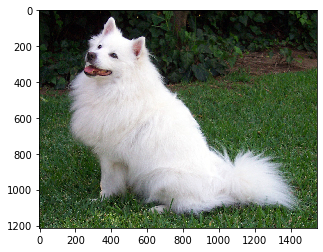

In [8]:
import urllib
import numpy as np
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
input_image = Image.open(filename)
def transform(img):
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
    img = np.array(img, dtype=np.uint8)
    img = img[:, :, ::-1]  # RGB -> BGR
    img = img.astype(np.float64)
    img -= mean_bgr
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img
img = transform(input_image)
plt.imshow(input_image)
plt.show()

In [9]:
from torchvision import transforms
input_batch = img.unsqueeze(0)
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
with torch.no_grad():
    score = model(input_batch)
lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
print(score.shape)

torch.Size([1, 21, 1213, 1546])


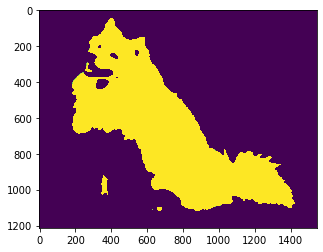

In [10]:
plt.imshow(lbl_pred[0])
plt.show()